In [1]:
import scripts.model as model
from scripts.config import *

vae = model.VAE()
vae.load(MODEL_NAME, MODEL_DIR)

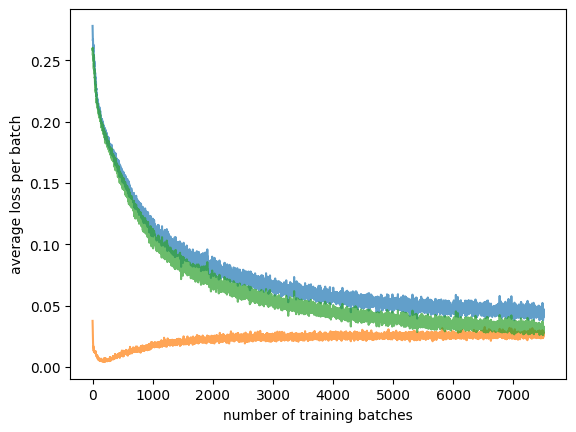

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(vae.loss_history["loss_total"], alpha=0.7)
plt.plot(np.array(vae.loss_history["kld_loss"])*0.0024, alpha=0.7)
plt.plot(np.array(vae.loss_history["mse_loss"]), alpha=0.7)
plt.xlabel("number of training batches")
plt.ylabel("average loss per batch")
plt.show()

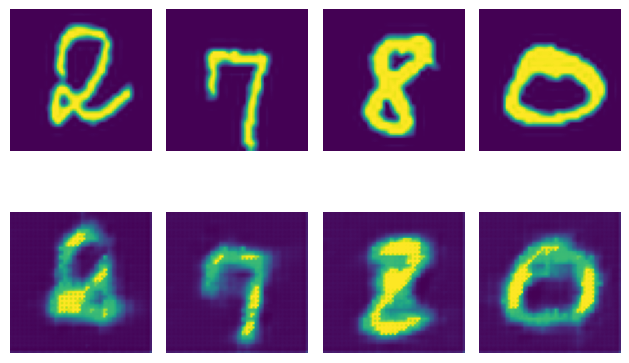

In [10]:
import torch
from scripts import util, dataset

device = util.get_device()
vae = vae.to(device)
vae.eval()

train_loader = dataset.get_train_loader(vae.input_shape, DATASET_NAME, DATASET_DIR, SUBSET_SIZE)
batch, _ = next(iter(train_loader))

with torch.no_grad():
    recon, _, _, _ = vae(batch.to(device))
    util.plot_image_grid(2, 4, torch.cat((batch[:4], recon[:4].cpu())))

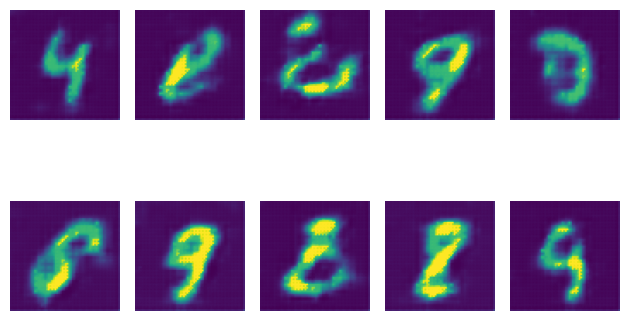

In [18]:
with torch.no_grad():
    z = torch.randn(10, LATENT_SIZE).to(device)
    recon = vae.decode(z)
    util.plot_image_grid(2, 5, recon.cpu())

In [19]:
# Get latent space representation
latents = []
labels = []

train_iter = iter(train_loader)

with torch.no_grad():
    for i in range(64):
        images, label = next(train_iter)
        images = images.to(device)
        recon, z, z_mean, z_log_var = vae(images)
        latents.append(z_mean)
        labels.append(label)

latents = torch.cat(latents).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()
print(latents.shape)
print(labels.shape)

(1024, 128)
(1024,)


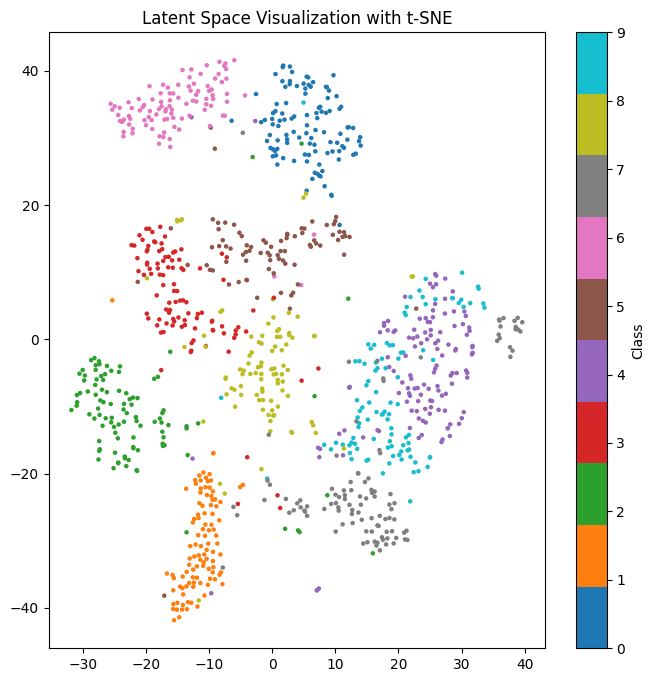

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d_tsne = tsne.fit_transform(latents)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))

scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=labels[:], cmap='tab10', s=5)

plt.colorbar(scatter, label="Class")
plt.title("Latent Space Visualization with t-SNE")
plt.show()